In [80]:
import requests
import json

# api-endpoint 

URL = "http://neu-3-1:18080/api/v1/applications"


# sending get request and saving the response as response object 
r = requests.get(url = URL) 
  
# extracting data in json format 
applications = r.json() 

In [83]:
import time 
import datetime 

def get_stages(app_id):
    print(app_id)
    URL = "http://neu-3-1:18080/api/v1/applications/%s/stages"%(app_id)
    # sending get request and saving the response as response object 
    if URL == "http://neu-3-1:18080/api/v1/applications/app-20200617160405-0036/stages":
        print(URL)
        
    URL="http://neu-3-1:18080/api/v1/applications/app-20200617160405-0036/stages"
        
    r = requests.get(url = URL) 
    #print(r)
    # extracting data in json format 
    stages = r.json() 

    for s in stages:
        submit_time = time.mktime(datetime.datetime.strptime(s['submissionTime'], 
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())        
        start_time = time.mktime(datetime.datetime.strptime(s['firstTaskLaunchedTime'], 
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
        completion_time = time.mktime(datetime.datetime.strptime(s['completionTime'], 
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
        #print(s['stageId'], s['inputBytes'], s['outputBytes'], s['rddIds'],
        #      s['numTasks'], completion_time - submit_time)
        
        #print(s.keys())
        #break

print(len(applications))
for app in applications:
    if app['id'] == 'app-20200619083519-0669':
        print(app['attempts'][0]['duration'])
        break
    
    
r

671
616814


<Response [200]>

In [ ]:
import pandas as pd

df = pd.read_csv('/local0/Kariz/expriments/runtime_prediction/micro/results/wordcount-spark.csv')
df

In [63]:
df[df['stage_id'] == 0][['dataset', 'bw', 'stride', 'runtime']]

cache_block_size = 4*1024*1024
one_gig = 1<<30
df['dataset_size'] = df['dataset'].map(lambda x: (int(x.rstrip('G'))<<30))



df2 = df[(df['bw']=='10Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)]

In [64]:
df2 = df[(df['bw']=='10Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)]

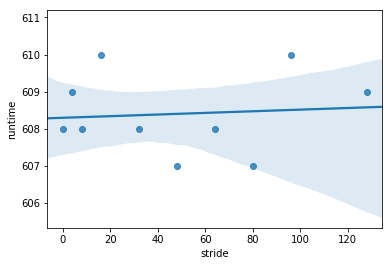

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.regplot(x='stride', y='runtime', 
            data=df[(df['bw']=='1Gbps') & (df['dataset']=='64G') & (df['stage_id']==0)])


#sns.regplot(x='stride', y='runtime', 
#            data=df[(df['bw']=='1Gbps') & (df['dataset']=='32G') & (df['stage_id']==0)])


#sns.regplot(x='stride', y='runtime', 
#            data=df[(df['bw']=='1Gbps') & (df['dataset']=='16G') & (df['stage_id']==0)])

#sns.regplot(x='stride', y='runtime', 
#            data=df[(df['bw']=='1Gbps') & (df['dataset']=='4G') & (df['stage_id']==0)])

plt.show()

In [59]:
df[(df['bw']=='40Gbps') & (df['stage_id']==0)]['dataset'].unique()

array(['1G', '4G', '16G', '32G', '64G'], dtype=object)

In [79]:
path = 's3a://data/HiBench/Wordcount/Input-64G'

path.split('data', 1)[1]

'/HiBench/Wordcount/Input-64G'